In [1]:
%matplotlib inline
from numpy import *
from matplotlib.pyplot import *
from scipy.optimize import minimize

class PointMassVehicle:
    def __init__(self,x=0,y=0,xdot=10,ydot=0,dT=0.01,umax = 5):
        self.x = x#initial x position of vehicle
        self.y = y#initial y position of vehicle
        self.xdot = xdot#vehicle forward velocity
        self.ydot = ydot
        self.umax = umax#maximum lateral acceleration
        self.dT = dT
    def updateStates(self,u):
        self.ydot = self.ydot+u*self.dT #euler update of vehicle velocity (constant acceleration)
        self.x = self.x+self.xdot*self.dT#euler update of vehicle position (constant velocity)
        self.y = self.y+self.ydot*self.dT
        #clamp acceleration at the maximum
        if abs(u)>self.umax:
            u = self.umax*sign(u)
        #update y velocity for next timestep

        return array([self.x,self.xdot,self.y,self.ydot])

class MPC_Vehicle:
    def __init__(self,K1,K2,K3,K4,umax,dtP,Np):
        self.K1,self.K2,self.K3,self.K4,self.umax,self.dtP,self.Np = K1,K2,K3,K4,umax,dtP,Np
        


In [6]:
def ObjectiveFn(uvec,yobstacle,xvehicle,pmvehicle,K1,K2,K3,K4):
        delta = 0.1
        #first reset the predictive model's states to where we are currently. 
        pmvehicle.x,pmvehicle.xdot,pmvehicle.y,pmvehicle.ydot = xvehicle[0],xvehicle[1],xvehicle[2],xvehicle[3]
        J = 0 #initialize the objective to zero
        #now loop through and update J for every timestep in the prediction horizon.
        for ind in range(0,len(uvec)): #compute for each step in the prediction horizon
            #print ind
            xv = pmvehicle.updateStates(uvec[ind])
            J = J + K1[ind]*uvec[ind]**2 + K2[ind] *(xv[2])**2 + K3[ind]*xv[3]**2+K4[ind] * 1/(xv[2]-yobstacle[ind]+delta)**2
        return J
#now create a function that the MPC algorithm uses to predict the obstacle's position
def MPC_predictobstaclepos(yo_now,vo_now,nsteps,dt):
    yobs_now = zeros(nsteps)
    yobs_now[0] = yo_now
    for ind in range(1,nsteps):
        yobs_now[ind] = yobs_now[ind-1]+dt*vo_now
    return yobs_now

1.69807439415 1.79807439415


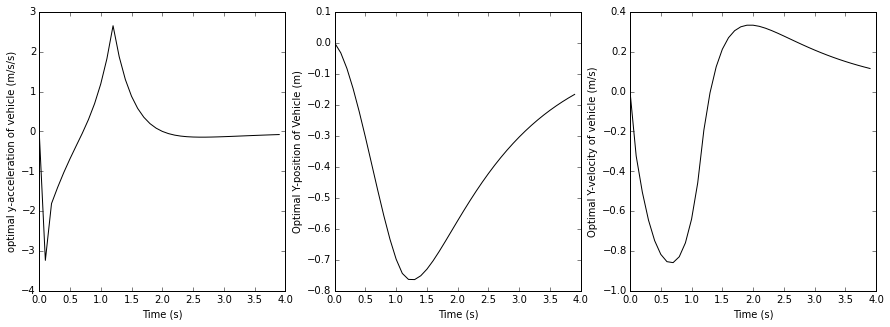

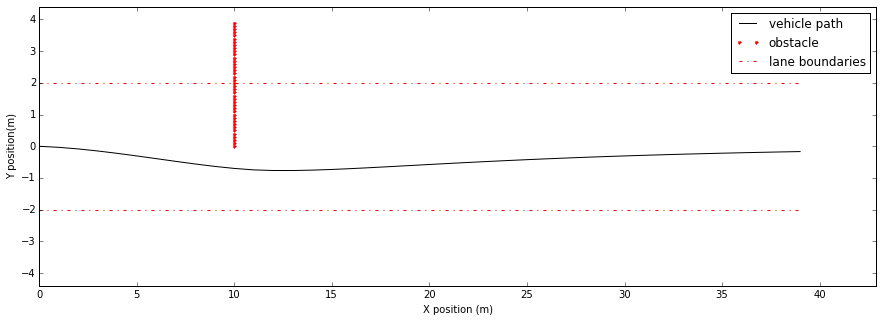

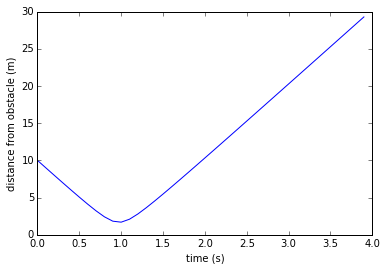

In [8]:

def runcollisionavoidance_cvmodel(simtime,dt,dtP,Np,uvmax,xdotv,ylane_left,ylane_right,W,K1mag,K2mag,K3mag,K4mag,xobs,yobs,ydotobs,plot_results=True):
    xv0 = 0#initial x-position of vehicle
    yv0=0 #initial y position of vehicle
    ydotv0 = 0# initial y velocity of vehicle
    u0 = 0#initial value of vehicle y-acceleration

    #optimizer variables
    K1 = K1mag*ones(Np)#weight on input
    K2 = K2mag*ones(Np)#weight on y vehicle
    #K3 = zeros(Np);K3[-1] = 1000#weight on terminal y-velocity. Only Penalize TERMINAL!!
    K3 = K3mag*ones(Np)#constant velocity penalty
    K4 = zeros(Np)#weight on distance from obstacle.
    delta = 0.1 # term added to inverse to avoid division by zero


    #set up things that will stay the same over time
    u0 = 0.10*random.randn(Np)#initialize vehicle acceleration to zeros for each of the 10 prediction timesteps
    vehiclepredict = PointMassVehicle(xv0,yv0,xdotv,ydotv0,dtP,uvmax)
    xvehicle = array([xv0,xdotv,yv0,ydotv0])
    #set up constraint on the optimization
    #set up the bounds on umax. This needs to be a list of tuples (min,max)
    bounds = [(-uvmax,uvmax)]
    for ind in range(1,len(u0)):
        bounds.insert(0,(-uvmax,uvmax))


    #set up time and time-dependent variables
    vehiclesimulate = PointMassVehicle(xv0,yv0,xdotv,ydotv0,dt,uvmax) #object to hold simulated vehicle states
    xvehicle_store = array([xv0,xdotv,yv0,ydotv0])
    u_store = array([0])#store the first value of each optimal input 
    t = arange(0,simtime,dt)#time vector

    vel_obstacle = ydotobs #m/s
    xvel_obstacle = 0 #m/s
    x_obstacle = xobs*ones(len(t)) # meters
    y_obstacle = zeros(len(t))#initialize obstacle position
    y_obstacle[0]=yobs #initial value
    for ind in range(1,len(t)):
        y_obstacle[ind] = y_obstacle[ind-1]+dt*vel_obstacle#update position 

    pass_error = 0
    for ind in range(1,len(t)):
        ##### WE must find the index in the vector of weights where we'll cross the obstacle

        #find the distnce from the obstacle
        obstacle_distance  = x_obstacle[ind]- vehiclesimulate.x#calculate the current distance from the obstacle
        if obstacle_distance>=0:
            #find the time to collision, assuming obstacle only moves in y-direction
            ttc = obstacle_distance/vehiclesimulate.xdot
            #now look at the vector of preview times for the prediction horizon
            preview_times = arange(0,Np*dtP,dtP)
            #now figure out which index in this vector most closely represents our collision time
            collision_index = argmin(abs(preview_times-ttc))
            #now set K4 
            K4 = zeros(Np)
            K4[collision_index] = K4mag
            if collision_index==0:
                pass_error = y_obstacle[ind]-vehiclesimulate.y
        else:
            K4 = zeros(Np)

        #pull out the y-position of the obstacle, use to predict future position for MPC algorithm
        yobs_now = MPC_predictobstaclepos(y_obstacle[ind],vel_obstacle,Np,dtP)#predict obstacle position
        #use current states, objective function, bounds, and predicted obstacle position to compute optimal input
        umpc = minimize(ObjectiveFn,u0,args=(yobs_now,xvehicle,vehiclepredict,K1,K2,K3,K4),bounds=bounds,method='SLSQP',options={'disp': False})
        opt_u = umpc.x#pull out the optimal input
        xvehicle = vehiclesimulate.updateStates(opt_u[0])
        xvehicle_store = vstack((xvehicle_store,xvehicle))
        u_store = append(u_store,opt_u[0])

    distance = sqrt((xvehicle_store[:,2]-y_obstacle)**2+(xvehicle_store[:,0]-x_obstacle)**2)
    miss_margin = min(distance)
    
    if plot_results==True:
        #now plot the input vector U and the vehicle y-position and y-velocity
        figure(figsize=(15,5))
        subplot(1,3,1)
        plot(t,u_store,'k')
        xlabel('Time (s)')
        ylabel('optimal y-acceleration of vehicle (m/s/s)')
        subplot(1,3,2)
        plot(t,xvehicle_store[:,2],'k')
        xlabel('Time (s)')
        ylabel('Optimal Y-position of Vehicle (m)')
        subplot(1,3,3)
        plot(t,xvehicle_store[:,3],'k')
        xlabel('Time (s)')
        ylabel('Optimal Y-velocity of vehicle (m/s)')

        figure(figsize=(15,5))
        plot(xvehicle_store[:,0],xvehicle_store[:,2],'k',x_obstacle,y_obstacle,'r.',[0, max(xvehicle_store[:,0])],[ylane_left,ylane_left],'r-.',[0, max(xvehicle_store[:,0])],[ylane_right,ylane_right],'r-.')
        ylim([-1.1*W,1.1*W])
        xlim([1.1*min(xvehicle_store[:,0]),1.1*max(xvehicle_store[:,0])])
        xlabel('X position (m)')
        ylabel('Y position(m)')
        legend(['vehicle path','obstacle','lane boundaries'])
        
        figure()
        plot(t,distance)
        xlabel('time (s)')
        ylabel('distance from obstacle (m)')
    
    
    
    return miss_margin,pass_error,xvehicle_store,u_store,x_obstacle,y_obstacle

#simulation variables
dtP = 0.1
Np = 10

dt = 0.1
simtime = 4 #second
#gravitational constant
g = 9.81 #m/s/s

#vehicle parameters
uvmax = 0.6*g #the maximum lateral acceleration for the vehicle.
xdotv = 10 #m/s



#environment variables
ylane_right = -2 #meters
ylane_left = 2 #meters, left lane boundary
W = ylane_left-ylane_right

K1mag = 0.1
K2mag = 1
K3mag = 1
K4mag = 100

xobs = 10
yobs = 0
ydotobs = 1



miss_margin,pass_error,junk1,junk2,junk3,junk4=runcollisionavoidance_cvmodel(simtime,dt,dtP,Np,uvmax,xdotv,ylane_left,ylane_right,W,K1mag,K2mag,K3mag,K4mag,xobs,yobs,ydotobs,True)
print miss_margin,pass_error

In [10]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib
import matplotlib.cm as cm
import IPython.display as IPdisplay
import glob
from PIL import Image as PIL_Image
from images2gif2 import writeGif


def make3dgif_fig_collision(gif_filename,possible_yobs,possible_ydotobs,pass_margin,miss):


    fig = figure(figsize=(10,10))
    ax = fig.add_subplot(111, projection='3d')
    for posind in range(0,len(possible_yobs)):
        for velind in range(0,len(possible_ydotobs)):
            if abs(pass_margin[posind,velind])>miss:
                ax.scatter(possible_yobs[posind],possible_ydotobs[velind],pass_margin[posind,velind],c='k')
            else:
                ax.scatter(possible_yobs[posind],possible_ydotobs[velind],pass_margin[posind,velind],c='r')

    for n in range(0, 100):
        if n >= 20 and n <= 22:
            ax.set_xlabel('')
            ax.set_ylabel('') #don't show axis labels while we move around, it looks weird
            ax.elev = ax.elev-0.5 #start by panning down slowly
        if n >= 23 and n <= 36:
            ax.elev = ax.elev-1.0 #pan down faster
        if n >= 37 and n <= 60:
            ax.elev = ax.elev-.5
            ax.azim = ax.azim+2.1 #pan down faster and start to rotate
        if n >= 61 and n <= 64:
            ax.elev = ax.elev-1.0
            ax.azim = ax.azim+1.1 #pan down slower and rotate same speed
        if n >= 65 and n <= 73:
            ax.elev = ax.elev-0.5
            ax.azim = ax.azim+1.1 #pan down slowly and rotate same speed
        if n >= 74 and n <= 76:
            ax.elev = ax.elev-0.2
            ax.azim = ax.azim+0.5 #end by panning/rotating slowly to stopping position
        if n == 77: #add axis labels at the end, when the plot isn't moving around
            ax.set_xlabel('obstacle start location (m)')
            ax.set_ylabel('obstacle velocity (m/s)')
            ax.set_zlabel('miss margin (m)')

        savefig('snaps/' + gif_filename + '/img' + str(n).zfill(3) + '.png',
                    bbox_inches='tight')


    close()
    path = 'snaps/' + gif_filename + '/*.png'
    #print path
    images = [PIL_Image.open(image) for image in glob.glob(path)]
    #print images
    file_path_name = gif_filename + '.gif'
    #print file_path_name
    writeGif(file_path_name, images, duration=0.1)


In [11]:
import os
K4 = 10*ones(Np)#weight on distance from obstacle.
possible_yobs = linspace(-W/2,W/2,10)#50 initial locations
possible_ydotobs = linspace(0.1,3,10)#50 possible velocities for the pedestrian
miss = 0.5 #meters, the acceptable miss margin

pass_margin = zeros((len(possible_yobs),len(possible_ydotobs)))
#keep track of cases we should look at (where we collide)
fail_case_yobs = array([])
fail_case_ydotobs = array([])
pass_margin_y = zeros((len(possible_yobs),len(possible_ydotobs)))

for posind in range(0,len(possible_yobs)):
    for velind in range(0,len(possible_ydotobs)):
        pass_margin[posind,velind],pass_margin_y[posind,velind],j1,j2,j3,j4=runcollisionavoidance_cvmodel(simtime,dt,dtP,Np,uvmax,xdotv,ylane_left,ylane_right,W,K1mag,K2mag,K3mag,K4mag,xobs,possible_yobs[posind],possible_ydotobs[velind],False)
        if abs(pass_margin[posind,velind])<miss:
            fail_case_yobs = append(fail_case_yobs,possible_yobs[posind])
            fail_case_ydotobs = append(fail_case_ydotobs,possible_ydotobs[velind])

gif_filename = 'signed_ymargin'
os.system('mkdir snaps/'+gif_filename)

make3dgif_fig_collision(gif_filename,possible_yobs,possible_ydotobs,pass_margin_y,miss)
IPdisplay.Image(url=gif_filename+'.gif') 

In [12]:
gif_filename = 'unsigned_margin'
os.system('mkdir snaps/'+gif_filename)

make3dgif_fig_collision(gif_filename,possible_yobs,possible_ydotobs,pass_margin,miss)
IPdisplay.Image(url=gif_filename+'.gif') 